In [41]:
from one.api import ONE
from brainbox.io.one import SpikeSortingLoader
from ibllib.atlas import AllenAtlas
from brainbox.core import TimeSeries
from brainbox.processing import bin_spikes

# import jax.random
from vlgpax.model import Session
from vlgpax.kernel import RBF, RFF
from vlgpax import vi
from einops import rearrange
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import random
# import math

## EDA

In [2]:
pw = 'international'
one = ONE(base_url='https://openalyx.internationalbrainlab.org', password=pw, silent=True)
ba = AllenAtlas()
pid = '73ff4936-8cd3-4a75-a772-f563e67d249d'
eid = one.pid2eid(pid)[0]

In [3]:
sl = SpikeSortingLoader(pid=pid, one=one, atlas=ba)
spikes, clusters, channels = sl.load_spike_sorting()
clusters = sl.merge_clusters(spikes, clusters, channels)
trials = one.load_object(eid, 'trials', collection='alf')

(<Figure size 1600x900 with 4 Axes>,
 array([[<AxesSubplot: title={'center': '2020-08-19_1_NYU-21_probe00, 73ff4936-8cd3-4a75-a772-f563e67d249d \n4_804_128 spikes, 287 clusters'}>,
         <AxesSubplot: >],
        [<AxesSubplot: xlabel='time (secs)', ylabel='depth (um)'>,
         <AxesSubplot: title={'center': 'alf'}>]], dtype=object))

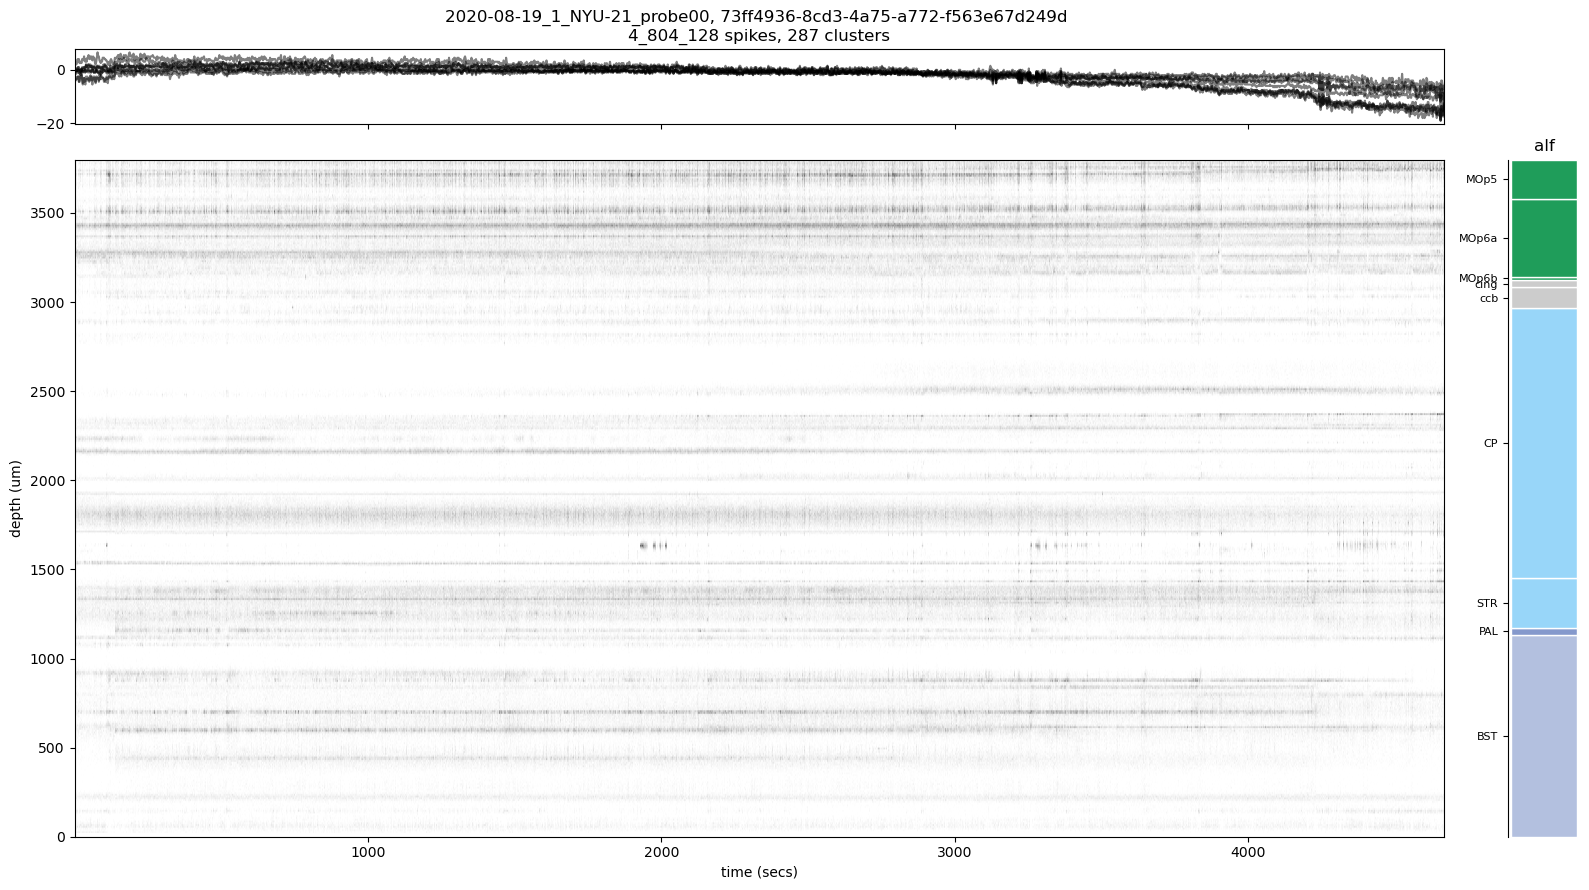

In [12]:
sl.raster(spikes, channels)

### Data Cleaning
1) Filter data for only good clusters (should indicate single neurons), and for brain regions MOp and MOs
2) Group spikes by neurons
3) Split data across trials
4) Bin spike times for each neuron, for each trial

In [20]:
# good_clusterIDs = clusters['cluster_id'][((clusters['label'] == 1) & ([True if "MO" in s else False for s in clusters['acronym']]))] # Find good clusters that are in MOp and MOs
# good_clusterIDs = clusters['cluster_id'][clusters['label'] == 1] # Find good clusters that are in MOp and MOs
good_clusterIDs = clusters['cluster_id'][((clusters['label'] > 0.5) & ([True if "MO" in s else False for s in clusters['acronym']]))] # Find good clusters that are in MOp and MOs
good_cluster_loc = np.isin(spikes['clusters'], good_clusterIDs)

In [21]:
good_spikes = {}
for i in spikes:
    good_spikes[i] = spikes[i][good_cluster_loc]

(<Figure size 1600x900 with 4 Axes>,
 array([[<AxesSubplot: title={'center': '2020-08-19_1_NYU-21_probe00, 73ff4936-8cd3-4a75-a772-f563e67d249d \n1_551_453 spikes, 58 clusters'}>,
         <AxesSubplot: >],
        [<AxesSubplot: xlabel='time (secs)', ylabel='depth (um)'>,
         <AxesSubplot: title={'center': 'alf'}>]], dtype=object))

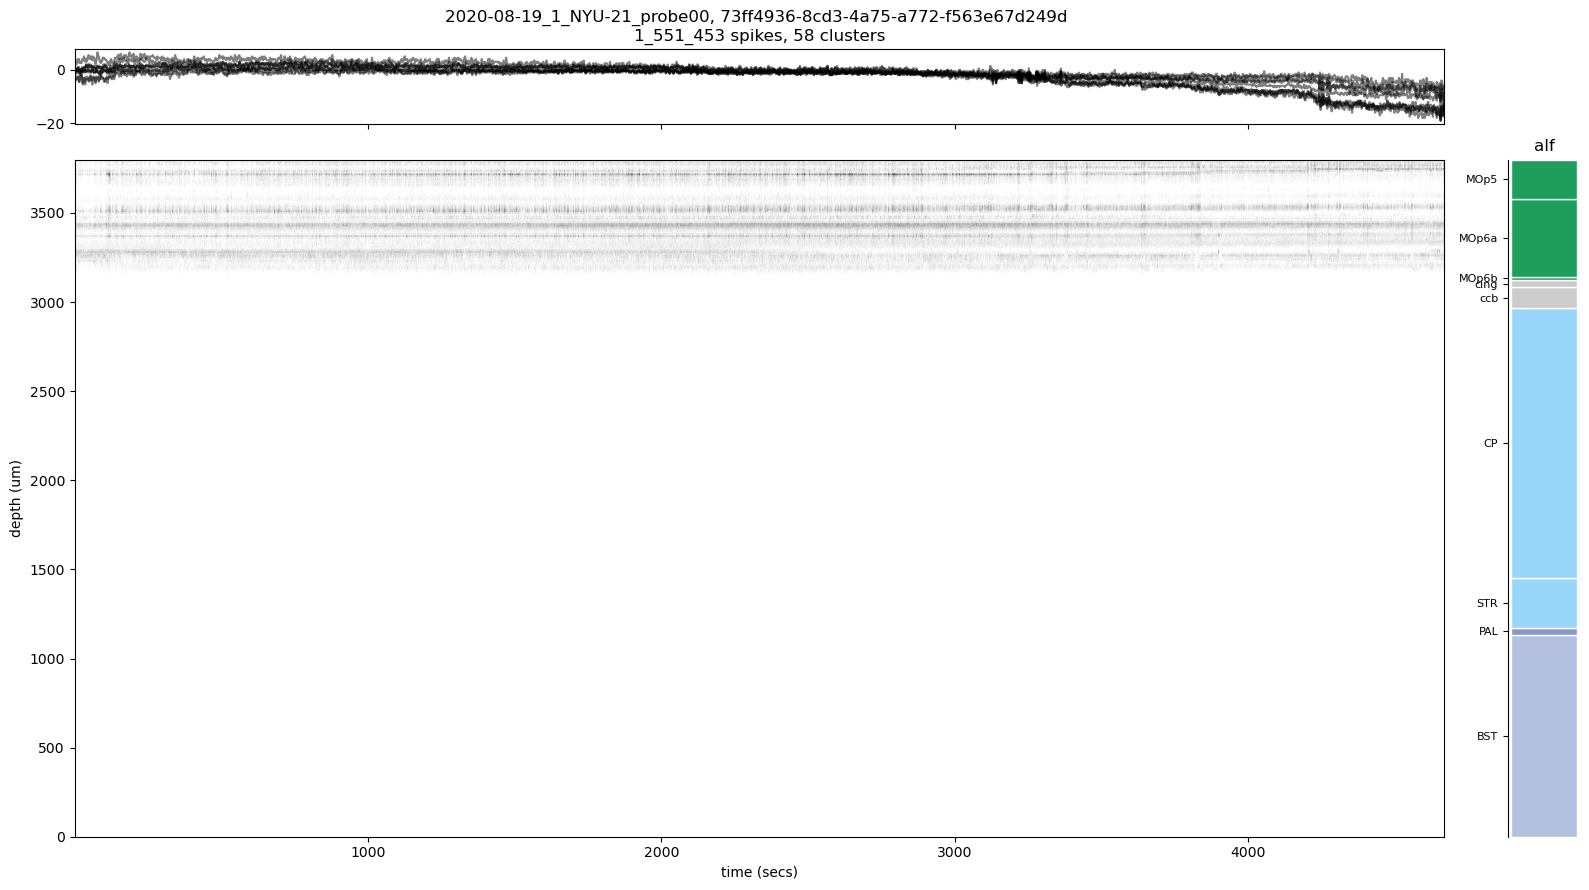

In [23]:
sl.raster(good_spikes, channels)

In [ ]:
np.unique(trials['choice'])

array([-1.,  1.])

In [ ]:
np.unique(trials['feedbackType'])

array([-1.,  1.])

In [187]:
bin_size = 50e-3 # in milliseconds
# min_bins = max(int((60e-3 / bin_size)), 20)
max_trial_type = 40 # Maximum number of trials of each trial type

In [188]:
# good_spikes
# All trials must have the same number of neurons
df = pd.DataFrame(data = {'clusters':good_spikes['clusters'], 'times':good_spikes['times']})
df = df.groupby('clusters')['times'].apply(np.array)

Implementation with bins as a fixed size:

In [24]:
# trials_spikes = [] # The Spike times and results of each trial

# for i in range(len(trials['goCueTrigger_times'])):
#     spike_range = {}
    
#     spike_range['goCue_times'] = trials['goCue_times'][i]
#     spike_range['firstMovement_times'] = trials['firstMovement_times'][i]
#     spike_range['choice'] = trials['choice'][i]
#     spike_range['feedbackType'] = trials['feedbackType'][i]
    
#     x = []
#     try:
#         hist_bins = np.arange(trials['goCueTrigger_times'][i], trials['firstMovement_times'][i], bin_size)
#     except:
#         continue
#         # the hist bins throw an error if the go cute or first movement time is NaN
#         # print(trials['goCueTrigger_times'][i], trials['firstMovement_times'][i])
    
#     if len(hist_bins) <= min_bins: # Mouse must have a minimum reaction time of 60 ms to be considered a good trial
#         continue
    
#     for j in df: # Iterate through spike times of each cluster
#         inds = ((j>trials['goCueTrigger_times'][i]) & (j<=trials['firstMovement_times'][i])) # From go queue to first movement
#         # print(np.histogram(j[inds], hist_bins)[0])
#         x.append(np.histogram(j[inds], hist_bins)[0])
    
#     spikes_df = pd.DataFrame(x, index=df.index)
#     spike_range['spikes_df'] = spikes_df
    
#     trials_spikes.append(spike_range)

Implementation with a set number of bins instead of bin size:

In [25]:
# trials_spikes = [] # The Spike times and results of each trial

# for i in range(len(trials['goCueTrigger_times'])):
#     spike_range = {}
    
#     spike_range['goCue_times'] = trials['goCue_times'][i]
#     spike_range['firstMovement_times'] = trials['firstMovement_times'][i]
#     spike_range['choice'] = trials['choice'][i]
#     spike_range['feedbackType'] = trials['feedbackType'][i]
    
#     x = []
    
#     time_range = (trials['firstMovement_times'][i] - trials['goCue_times'][i])
#     if ((time_range < 0.10) | (time_range > 0.300)): # Mouse must have a minimum reaction time of 60 ms to be considered a good trial. We also exlude trials longer than 300 ms because they will have too many spikes per bin
#         continue
    
#     for j in df: # Iterate through spike times of each cluster
#         inds = ((j>trials['goCueTrigger_times'][i]) & (j<=trials['firstMovement_times'][i])) # From go queue to first movement
#         # print(np.histogram(j[inds], hist_bins)[0])
#         x.append(np.histogram(j[inds], 200)[0]) # 200 bins
    
#     spikes_df = pd.DataFrame(x, index=df.index)
#     spike_range['spikes_df'] = spikes_df
    
#     trials_spikes.append(spike_range)

Implementation with bins starting 100ms before first movement to 300 ms after first movement

In [189]:
trials_spikes = [] # The Spike times and results of each trial

for i in range(len(trials['goCueTrigger_times'])):
    if (trials['firstMovement_times'][i] < trials['goCue_times'][i]+0.05):
        continue
    
    spike_range = {}
    
    spike_range['goCue_times'] = trials['goCue_times'][i]
    spike_range['firstMovement_times'] = trials['firstMovement_times'][i]
    spike_range['choice'] = trials['choice'][i]
    spike_range['feedbackType'] = trials['feedbackType'][i]
    
    x = []
    try:
        hist_bins = np.arange(trials['firstMovement_times'][i]-0.1, trials['firstMovement_times'][i]+1.00001, bin_size)
        # print(len(hist_bins))
    except:
        continue
        # the hist bins throw an error if the go cue or first movement time is NaN
        # print(trials['goCueTrigger_times'][i], trials['firstMovement_times'][i])
    
    
    for j in df: # Iterate through spike times of each cluster
        inds = ((j>(trials['firstMovement_times'][i]-0.1)) & (j<=(trials['firstMovement_times'][i]+1.00001))) # From go queue to first movement
        # print(np.histogram(j[inds], hist_bins)[0])
        x.append(np.histogram(j[inds], hist_bins)[0])
    
    spikes_df = pd.DataFrame(x, index=df.index)
    spike_range['spikes_df'] = spikes_df
    
    trials_spikes.append(spike_range)

In [27]:
random.shuffle(trials_spikes) # Randomize list before splitting into training and testing data

In [160]:
len(trials_spikes)

388

In [190]:
training_trials = []
testing_trials = []


trial_counts = {"correct_left" : [0, 0],  # [training count, testing count]
                "correct_right" : [0, 0],
                "incorrect_left" : [0, 0], # incorrect left means that the mouse chose left, and it was incorrect
                "incorrect_right": [0, 0]}

for i in trials_spikes:
    if ((i["choice"]==-1) & (i["feedbackType"]==1)):
        if trial_counts['correct_left'][0] < max_trial_type:
            training_trials.append(i)
            trial_counts['correct_left'][0] += 1
        elif trial_counts['correct_left'][1] < max_trial_type:
            testing_trials.append(i)
            trial_counts['correct_left'][1] += 1
        else:
            continue
    elif ((i["choice"]==1) & (i["feedbackType"]==1)):
        if trial_counts['correct_right'][0] < max_trial_type:
            training_trials.append(i)
            trial_counts['correct_right'][0] += 1
        elif trial_counts['correct_right'][1] < max_trial_type:
            testing_trials.append(i)
            trial_counts['correct_right'][1] += 1
        else:
            continue
    elif ((i["choice"]==-1) & (i["feedbackType"]==-1)):
        if trial_counts['incorrect_left'][0] < max_trial_type:
            training_trials.append(i)
            trial_counts['incorrect_left'][0] += 1
        elif trial_counts['incorrect_left'][1] < max_trial_type:
            testing_trials.append(i)
            trial_counts['incorrect_left'][1] += 1
        else:
            continue
    elif ((i["choice"]==1) & (i["feedbackType"]==-1)):
        if trial_counts['incorrect_right'][0] < max_trial_type:
            training_trials.append(i)
            trial_counts['incorrect_right'][0] += 1
        elif trial_counts['incorrect_right'][1] < max_trial_type:
            testing_trials.append(i)
            trial_counts['incorrect_right'][1] += 1
        else:
            continue

In [161]:
training_trials = trials_spikes[:250]
testing_trials = trials_spikes[250:]

In [31]:
len(training_trials)

144

In [33]:
training_trials[40]['spikes_df'].T

clusters,145,147,148,149,150,152,153,154,155,157,...,220,221,222,223,224,259,261,271,272,273
0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,1,0,0,1,0,2,0
1,0,0,0,0,0,0,0,1,0,1,...,0,0,2,0,1,0,1,0,1,0
2,1,0,0,0,0,0,0,0,2,2,...,0,3,3,2,0,0,0,1,1,0
3,0,0,1,0,0,0,0,2,3,0,...,0,3,1,0,0,0,0,1,1,0
4,0,0,0,0,0,0,0,0,1,1,...,0,3,3,1,0,0,0,0,1,0
5,0,0,0,0,0,0,0,0,0,1,...,0,1,3,0,0,0,0,0,1,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1,1,0,...,0,1,1,0,0,1,0,0,0,0
8,1,0,0,0,0,0,0,0,0,1,...,0,2,0,0,0,3,0,0,0,0
9,0,0,0,0,0,0,0,0,2,0,...,0,2,0,0,0,6,0,0,0,0


In [191]:
session = Session(bin_size)
for i, trial in enumerate(training_trials):
    session.add_trial(i, y=trial['spikes_df'].T)

In [192]:
length_scale = 0.200 # in seconds
kernel = RBF(scale=1, lengthscale=length_scale)

In [193]:
session, params = vi.fit(session, n_factors=2, kernel=kernel, seed=10, max_iter=15, trial_length=20, GPFA=True)

Initializing
Initialized


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:270: UserWarning:

M: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



EM Iteration 1, 	Loss = 25.0022, 	M step: 2.15s, 	E step: 10.58s
EM Iteration 2, 	Loss = 24.7471, 	M step: 1.24s, 	E step: 9.82s
EM Iteration 3, 	Loss = 24.6804, 	M step: 0.71s, 	E step: 10.03s
EM Iteration 4, 	Loss = 24.6275, 	M step: 0.74s, 	E step: 9.37s
EM Iteration 5, 	Loss = 24.5811, 	M step: 0.96s, 	E step: 9.62s
EM Iteration 6, 	Loss = 24.5492, 	M step: 0.87s, 	E step: 8.82s
EM Iteration 7, 	Loss = 24.5311, 	M step: 0.80s, 	E step: 9.23s
EM Iteration 8, 	Loss = 24.5209, 	M step: 0.78s, 	E step: 8.70s
EM Iteration 9, 	Loss = 24.5154, 	M step: 0.68s, 	E step: 9.59s
EM Iteration 10, 	Loss = 24.5131, 	M step: 0.78s, 	E step: 9.03s
EM Iteration 11, 	Loss = 24.5132, 	M step: 0.62s, 	E step: 9.54s
EM: stopped at convergence
Inferring
Trial 0, 	Loss = 32.7465
Trial 1, 	Loss = 30.1422
Trial 2, 	Loss = 29.5935
Trial 3, 	Loss = 23.8137
Trial 4, 	Loss = 25.5464


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:173: UserWarning:

E: maximum number of iterations reached



Trial 5, 	Loss = 28.1722
Trial 6, 	Loss = 22.9419
Trial 7, 	Loss = 24.8200
Trial 8, 	Loss = 27.1952
Trial 9, 	Loss = 21.2596
Trial 10, 	Loss = 23.5951
Trial 11, 	Loss = 24.1450
Trial 12, 	Loss = 24.9853
Trial 13, 	Loss = 21.5410
Trial 14, 	Loss = 25.0517
Trial 15, 	Loss = 24.1764
Trial 16, 	Loss = 24.2068
Trial 17, 	Loss = 23.7674
Trial 18, 	Loss = 24.9717
Trial 19, 	Loss = 19.6021
Trial 20, 	Loss = 20.6062
Trial 21, 	Loss = 15.3800
Trial 22, 	Loss = 19.9676
Trial 23, 	Loss = 27.1801
Trial 24, 	Loss = 21.4538
Trial 25, 	Loss = 21.8761
Trial 26, 	Loss = 22.7829
Trial 27, 	Loss = 23.6350
Trial 28, 	Loss = 21.5774
Trial 29, 	Loss = 21.1514
Trial 30, 	Loss = 20.8233
Trial 31, 	Loss = 21.9301
Trial 32, 	Loss = 27.2248
Trial 33, 	Loss = 19.7506
Trial 34, 	Loss = 30.6192
Trial 35, 	Loss = 19.9182
Trial 36, 	Loss = 20.1021
Trial 37, 	Loss = 27.9653
Trial 38, 	Loss = 23.6376
Trial 39, 	Loss = 23.0833
Trial 40, 	Loss = 19.4599
Trial 41, 	Loss = 17.9153
Trial 42, 	Loss = 31.6361
Trial 43, 	Loss =

In [194]:
# trials_spikes[2]['spikes_df'].T.to_csv("neural_data.csv")

In [195]:
# Find testing trajectories
sessionTest = Session(bin_size)
for i, trial in enumerate(testing_trials):
    sessionTest.add_trial(i, y=trial['spikes_df'].T)

sessionTest = vi.infer(sessionTest, params=params, )
z_test = rearrange(sessionTest.z, '(trials time) lat -> trials time lat', time=testing_trials[0]['spikes_df'].shape[1])

Trial 0, 	Loss = 26.2555
Trial 1, 	Loss = 25.2265
Trial 2, 	Loss = 25.0900
Trial 3, 	Loss = 23.4664
Trial 4, 	Loss = 24.1596


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Trial 5, 	Loss = 22.6385
Trial 6, 	Loss = 24.7085
Trial 7, 	Loss = 23.5876
Trial 8, 	Loss = 23.7818
Trial 9, 	Loss = 22.9186
Trial 10, 	Loss = 22.1284
Trial 11, 	Loss = 21.7666
Trial 12, 	Loss = 25.0702
Trial 13, 	Loss = 23.8030
Trial 14, 	Loss = 23.3480
Trial 15, 	Loss = 27.0613
Trial 16, 	Loss = 25.2875
Trial 17, 	Loss = 25.4042
Trial 18, 	Loss = 30.6398
Trial 19, 	Loss = 26.1941
Trial 20, 	Loss = 28.8628
Trial 21, 	Loss = 23.1221
Trial 22, 	Loss = 22.8814


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:173: UserWarning:

E: maximum number of iterations reached



Trial 23, 	Loss = 29.1346
Trial 24, 	Loss = 31.7518
Trial 25, 	Loss = 27.5192
Trial 26, 	Loss = 32.4343
Trial 27, 	Loss = 23.0220
Trial 28, 	Loss = 21.1429
Trial 29, 	Loss = 29.8198
Trial 30, 	Loss = 25.2064
Trial 31, 	Loss = 23.9763
Trial 32, 	Loss = 27.0430
Trial 33, 	Loss = 28.5030
Trial 34, 	Loss = 27.8607
Trial 35, 	Loss = 28.2906
Trial 36, 	Loss = 26.3135
Trial 37, 	Loss = 32.0463
Trial 38, 	Loss = 23.1193
Trial 39, 	Loss = 28.8150
Trial 40, 	Loss = 27.1908
Trial 41, 	Loss = 25.6741
Trial 42, 	Loss = 25.2631
Trial 43, 	Loss = 23.7140
Trial 44, 	Loss = 30.8756
Trial 45, 	Loss = 30.7938
Trial 46, 	Loss = 27.3890
Trial 47, 	Loss = 22.2397
Trial 48, 	Loss = 27.8545
Trial 49, 	Loss = 25.2042
Trial 50, 	Loss = 27.7382
Trial 51, 	Loss = 25.1739
Trial 52, 	Loss = 30.9552
Trial 53, 	Loss = 22.9324
Trial 54, 	Loss = 25.9257
Trial 55, 	Loss = 24.4542
Trial 56, 	Loss = 30.4228
Trial 57, 	Loss = 26.1934
Trial 58, 	Loss = 29.7861
Trial 59, 	Loss = 26.1479
Trial 60, 	Loss = 31.2818
Trial 61, 	L

### Plot training trajectories and add them to test set. Plot test trajectories after


In [196]:
z_train = rearrange(session.z, '(trials time) lat -> trials time lat', time=training_trials[0]['spikes_df'].shape[1])

first = True
time_sig = 4
X_class_train = []
y_class_train = []
time_bins = len(z_train[i][:, 0])

for i in range(len(z_train)):
    if ((training_trials[i]['choice']==1) & (training_trials[i]['feedbackType']==1)):
        if first:
            fig = px.line_3d(x=np.arange(time_bins), y=z_train[i][:, 0], z=z_train[i][:, 1], color=["blue"]*time_bins, width=800, height=800)
            first = False
        else:
            fig.add_scatter3d(x=np.arange(time_bins), y=z_train[i][:, 0], z=z_train[i][:, 1], mode='lines', line={'color':"blue"}, opacity=0.5)
        # fig.add_scatter3d(x=[time_sig], y=z_train[i][time_sig:time_sig+1, 0], z=z_train[i][time_sig:time_sig+1, 1], mode='markers', marker={'color':'green', 'size':5})  # show point of significance
        X_class_train.append(z_train[i][time_sig]); y_class_train.append(0)
        
    elif ((training_trials[i]['choice']==-1) & (training_trials[i]['feedbackType']==1)):
        if first:
            fig = px.line_3d(x=np.arange(time_bins), y=z_train[i][:, 0], z=z_train[i][:, 1], color=["red"]*time_bins, width=800, height=800)
            first = False
        else:
            fig.add_scatter3d(x=np.arange(time_bins), y=z_train[i][:, 0], z=z_train[i][:, 1], mode='lines', line={'color':"red"}, opacity=0.5)
        # fig.add_scatter3d(x=[time_sig], y=z_train[i][time_sig:time_sig+1, 0], z=z_train[i][time_sig:time_sig+1, 1], mode='markers', marker={'color':'black', 'size':5})  # show point of significance
        X_class_train.append(z_train[i][time_sig]); y_class_train.append(1)
        
    elif ((training_trials[i]['choice']==1) & (training_trials[i]['feedbackType']==-1)):
        # if first:
        #     fig = px.line_3d(x=np.arange(time_bins), y=z_test[i][:, 0], z=z_test[i][:, 1], color=["green"]*time_bins, width=800, height=800)
        #     first = False
        # else:
        #     fig.add_scatter3d(x=np.arange(time_bins), y=z_test[i][:, 0], z=z_test[i][:, 1], mode='lines', line={'color':"green"}, opacity=0.5)
        X_class_train.append(z_train[i][time_sig]); y_class_train.append(2)
        
    elif ((training_trials[i]['choice']==-1) & (training_trials[i]['feedbackType']==-1)):
        # if first:
        #     fig = px.line_3d(x=np.arange(time_bins), y=z_test[i][:, 0], z=z_test[i][:, 1], color=["black"]*time_bins, width=800, height=800)
        #     first = False
        # else:
        #     fig.add_scatter3d(x=np.arange(time_bins), y=z_test[i][:, 0], z=z_test[i][:, 1], mode='lines', line={'color':"black"}, opacity=1)
        X_class_train.append(z_train[i][time_sig]); y_class_train.append(3)
        

X_class_test = []
y_class_test = []

# Plot testing trajectories
for i in range(len(z_test)):
    if ((testing_trials[i]['choice']==1) & (testing_trials[i]['feedbackType']==1)):
        if first:
            fig = px.line_3d(x=np.arange(time_bins), y=z_test[i][:, 0], z=z_test[i][:, 1], color=["green"]*time_bins, width=800, height=800)
            first = False
        else:
            fig.add_scatter3d(x=np.arange(time_bins), y=z_test[i][:, 0], z=z_test[i][:, 1], mode='lines', line={'color':"green"}, opacity=0.5)
        # fig.add_scatter3d(x=[time_sig], y=z_train[i][time_sig:time_sig+1, 0], z=z_train[i][time_sig:time_sig+1, 1], mode='markers', marker={'color':'green', 'size':5})  # show point of significance
        X_class_test.append(z_test[i][time_sig]); y_class_test.append(0)
        
    elif ((testing_trials[i]['choice']==-1) & (testing_trials[i]['feedbackType']==1)):
        if first:
            fig = px.line_3d(x=np.arange(time_bins), y=z_test[i][:, 0], z=z_test[i][:, 1], color=["black"]*time_bins, width=800, height=800)
            first = False
        else:
            fig.add_scatter3d(x=np.arange(time_bins), y=z_test[i][:, 0], z=z_test[i][:, 1], mode='lines', line={'color':"black"}, opacity=0.5)
        # fig.add_scatter3d(x=[time_sig], y=z_train[i][time_sig:time_sig+1, 0], z=z_train[i][time_sig:time_sig+1, 1], mode='markers', marker={'color':'black', 'size':5})  # show point of significance
        X_class_test.append(z_test[i][time_sig]); y_class_test.append(1)
        
    elif ((testing_trials[i]['choice']==1) & (testing_trials[i]['feedbackType']==-1)):
        X_class_test.append(z_test[i][time_sig]); y_class_test.append(2)
        
    elif ((testing_trials[i]['choice']==-1) & (testing_trials[i]['feedbackType']==-1)):
        X_class_test.append(z_test[i][time_sig]); y_class_test.append(3)

X_class_train = np.array(X_class_train)
y_class_train = np.array(y_class_train)
X_class_test = np.array(X_class_test)
y_class_test = np.array(y_class_test)

fig.show()

In [197]:
from sklearn.linear_model import LogisticRegression

mod = LogisticRegression()
mod.fit(X_class_train, y_class_train)
print(mod.score(X_class_train, y_class_train))
mod.score(X_class_test, y_class_test)

0.5555555555555556


0.6842105263157895

0.925
0.9625


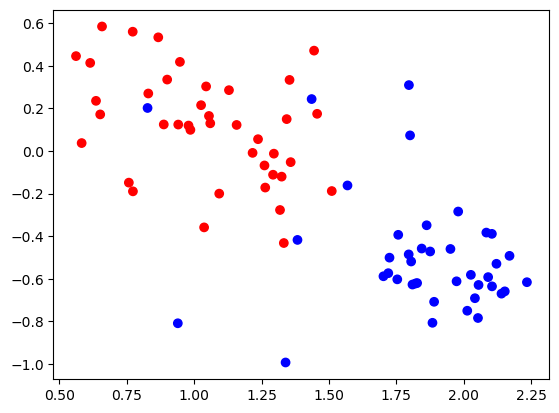

In [198]:
# Predict between Just correct left and correct right
X_class_train01 = X_class_train[((y_class_train==0) | (y_class_train==1))]
y_class_train01 = y_class_train[((y_class_train==0) | (y_class_train==1))]
X_class_test01 = X_class_test[((y_class_test==0) | (y_class_test==1))]
y_class_test01 = y_class_test[((y_class_test==0) | (y_class_test==1))]


mod = LogisticRegression()
mod.fit(X_class_train01, y_class_train01)
print(mod.score(X_class_train01, y_class_train01))
print(mod.score(X_class_test01, y_class_test01))
plt.scatter(X_class_train01[:, 0], X_class_train01[:, 1], color=np.array(['blue', 'red', 'green', 'black'])[y_class_train01])

0.625
1.0


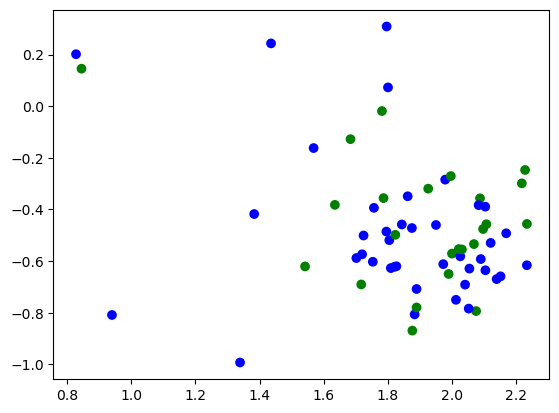

In [199]:
# Predict between Just correct left and incorrect left. Obtains a low accuracy compared to baseline
X_class_train02 = X_class_train[((y_class_train==0) | (y_class_train==2))]
y_class_train02 = y_class_train[((y_class_train==0) | (y_class_train==2))]
X_class_test02 = X_class_test[((y_class_test==0) | (y_class_test==2))]
y_class_test02 = y_class_test[((y_class_test==0) | (y_class_test==2))]


mod = LogisticRegression()
mod.fit(X_class_train02, y_class_train02)
print(mod.score(X_class_train02, y_class_train02))
print(mod.score(X_class_test02, y_class_test02)) # is 1 because the test set is unbalanced

plt.scatter(X_class_train02[:, 0], X_class_train02[:, 1], color=np.array(['blue', 'red', 'green', 'black'])[y_class_train02])

0.8
0.9272727272727272


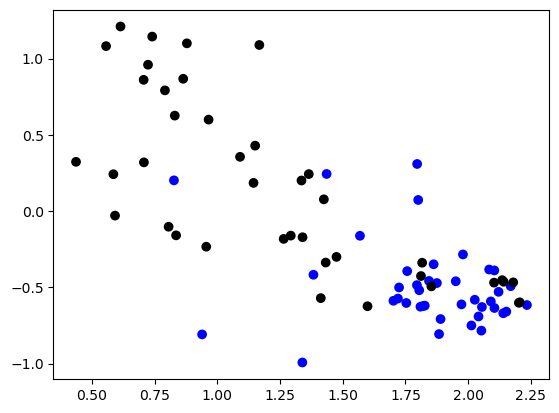

In [200]:
# Predict between correct left and incorrect right
X_class_train03 = X_class_train[((y_class_train==0) | (y_class_train==3))]
y_class_train03 = y_class_train[((y_class_train==0) | (y_class_train==3))]
X_class_test03 = X_class_test[((y_class_test==0) | (y_class_test==3))]
y_class_test03 = y_class_test[((y_class_test==0) | (y_class_test==3))]


mod = LogisticRegression()
mod.fit(X_class_train03, y_class_train03)
print(mod.score(X_class_train03, y_class_train03))
print(mod.score(X_class_test03, y_class_test03))

plt.scatter(X_class_train03[:, 0], X_class_train03[:, 1], color=np.array(['blue', 'red', 'green', 'black'])[y_class_train03])